# Modelo para la detección de Bots en Twitter

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import xgboost as xgb
mpl.rcParams['patch.force_edgecolor'] = True
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [11]:
# Cargamos el Google Drive para almacenar los archivos
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
FOLDER_PATH="/content/drive/MyDrive/RECOMENDACION V2"

In [13]:
# Definimos la ruta del archivo con los datos sobre Bots
#file= FOLDER_PATH+'/training_data_2_csv_UTF.csv'
file= FOLDER_PATH+'/dataset.csv'


Dataset "dataset.csv": 

This dataset contains both genuine users (3474) and social spambots (4912) and has 69 features defined for each of these accounts. Such features can be divided in 3 categories: content, account information or account usage features.
Claudia Cea. (2021). Dataset for supervised bot detection on Twitter (1.0) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.5574403

In [14]:
# Cargamos los datos y definimos variables para Bots y NoBots 
training_data = pd.read_csv(file, low_memory=False)

In [15]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8386 entries, 0 to 8385
Data columns (total 69 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   class_bot                             8386 non-null   int64  
 1   id                                    8386 non-null   int64  
 2   statuses_count                        8386 non-null   int64  
 3   followers_count                       8386 non-null   int64  
 4   friends_count                         8386 non-null   int64  
 5   favourites_count                      8386 non-null   int64  
 6   listed_count                          8386 non-null   int64  
 7   default_profile                       8386 non-null   float64
 8   default_profile_image                 8386 non-null   float64
 9   geo_enabled                           8386 non-null   float64
 10  profile_use_background_image          8386 non-null   float64
 11  profile_backgroun

In [16]:
training_data.head()

,class_bot,id,statuses_count,followers_count,friends_count,favourites_count,listed_count,default_profile,default_profile_image,geo_enabled,...,reply_status_ratio,avg_urls_status_ratio,avg_mentions_status_ratio,avg_favorite_status_ratio,account_age,followers_account_age_ratio,friends_account_age_ratio,statuses_account_age_ratio,favourites_account_age_ratio,lists_account_age_ratio
0,0,678033,45825,7065,1822,3804,596,0.0,0.0,0.0,...,0.023655,0.000006,0.000024,0.000011,127286.0,0.055505,0.014314,0.360016,0.029885,0.004682
1,0,722623,11770,1577,678,634,47,0.0,0.0,1.0,...,0.076381,0.000014,0.000060,0.000035,127119.0,0.012406,0.005334,0.092590,0.004987,0.000370
2,0,755116,39158,623,529,42,37,0.0,0.0,0.0,...,0.042495,0.000003,0.000024,0.000004,126923.0,0.004908,0.004168,0.308518,0.000331,0.000292
3,0,755746,18035,1620,591,361,72,0.0,0.0,1.0,...,0.062212,0.000026,0.000038,0.000005,126899.0,0.012766,0.004657,0.142121,0.002845,0.000567
4,0,785080,22496,821,552,5897,29,0.0,0.0,0.0,...,0.061655,0.000003,0.000035,0.000023,126567.0,0.006487,0.004361,0.177740,0.046592,0.000229


In [17]:
bots = training_data[training_data.class_bot==1]
nonbots = training_data[training_data.class_bot==0]
bots['name_entropy'].mean()

3.2113685924450923

In [18]:
nonbots['name_entropy'].mean()

2.7924966795250175

In [19]:
#training_data['bot'].value_counts()
training_data['class_bot'].value_counts()

1    4912
0    3474
Name: class_bot, dtype: int64

In [20]:
training_data = training_data.dropna()

In [21]:
training_data.shape

(8386, 69)

### Exploratory Data Analysis

In [22]:
# Identifying Missingness in the data (NaN visualization)
def get_heatmap(df):
    #This function gives heatmap of all NaN values
    plt.figure(figsize=(10,6))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
    plt.tight_layout()
    return plt.show()

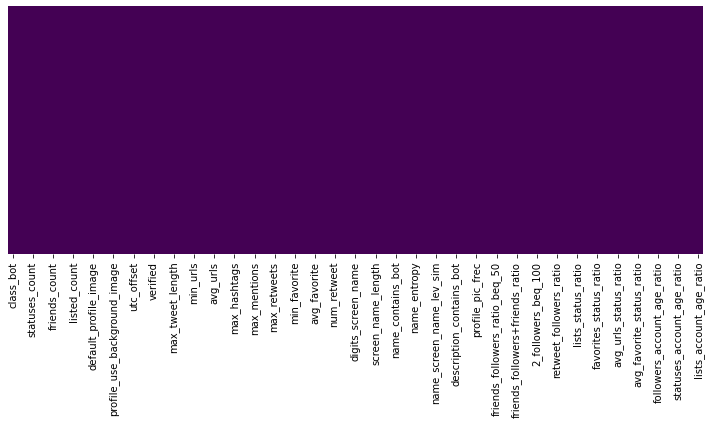

In [23]:
get_heatmap(training_data)

In [24]:
bots.friends_count/bots.followers_count

3474     1.818182
3475     0.274023
3476     1.258333
3477     0.879397
3478     0.980630
          ...    
8381     5.750000
8382    10.000000
8383     4.275862
8384     3.069565
8385     7.392593
Length: 4912, dtype: float64

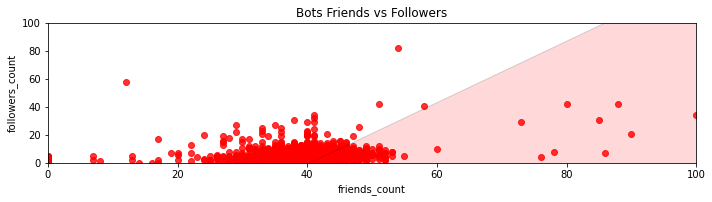

In [25]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title('Bots Friends vs Followers')
sns.regplot(bots.friends_count, bots.followers_count, color='red', label='Bots')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.tight_layout()

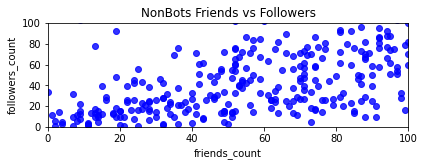

In [26]:
plt.subplot(2,1,2)
plt.title('NonBots Friends vs Followers')
sns.regplot(nonbots.friends_count, nonbots.followers_count, color='blue', label='NonBots')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

### Identifying Imbalance in the data

In [27]:
bots['friends_by_followers'] = bots.friends_count/bots.followers_count
bots[bots.friends_by_followers<1].shape

(255, 70)

In [28]:
nonbots['friends_by_followers'] = nonbots.friends_count/nonbots.followers_count
nonbots[nonbots.friends_by_followers<1].shape

(1828, 70)

(4449, 70)


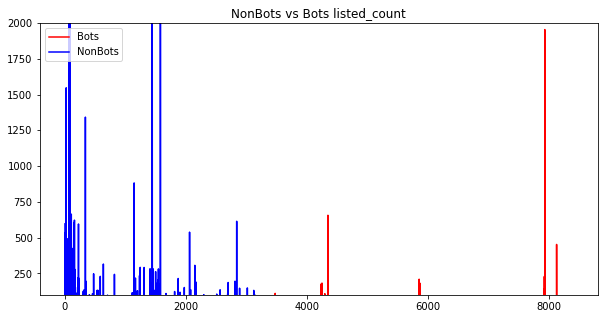

In [29]:
plt.figure(figsize=(10,5))
plt.title('NonBots vs Bots listed_count')
plt.plot(bots.listed_count, color='red', label='Bots')
plt.plot(nonbots.listed_count, color='blue', label='NonBots')
plt.legend(loc='upper left')
plt.ylim(100,2000)
print(bots[(bots.listed_count<5)].shape)

In [30]:
bots_listed_count_df = bots[bots.listed_count<2000]
nonbots_listed_count_df = nonbots[nonbots.listed_count<2000]

bots_verified_df = bots_listed_count_df[bots_listed_count_df.verified==False]
#bots_screenname_has_bot_df_ = bots_verified_df[(bots_verified_df.screen_name.str.contains("bot", case=False)==True)].shape

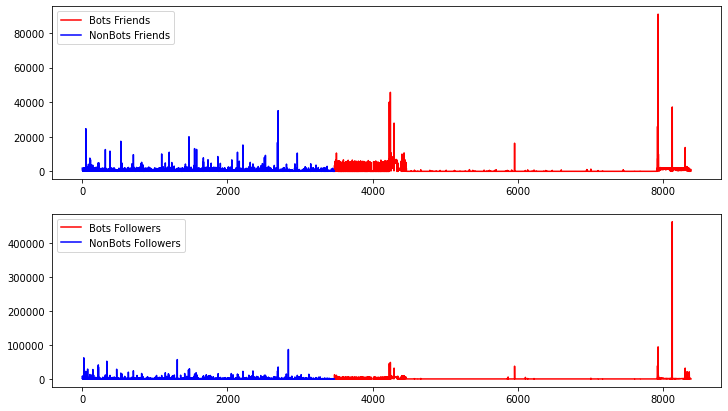

In [31]:
plt.figure(figsize=(12,7))

plt.subplot(2,1,1)
plt.plot(bots_listed_count_df.friends_count, color='red', label='Bots Friends')
plt.plot(nonbots_listed_count_df.friends_count, color='blue', label='NonBots Friends')
plt.legend(loc='upper left')

plt.subplot(2,1,2)
plt.plot(bots_listed_count_df.followers_count, color='red', label='Bots Followers')
plt.plot(nonbots_listed_count_df.followers_count, color='blue', label='NonBots Followers')
plt.legend(loc='upper left')

### Feature Independence using Spearman correlation

In the Spearman’s rank correlation coefficient not all features
contribute equally to the prediction of the target value.
As described in Section 3.1, there are features that have
a strong correlation with the label/output, while there are
others that have a low or even no correlation with the label.
Furthermore, the correlation between features should be
considered. Highly correlated features to each other have
nothing more to offer to the final prediction rather than
increasing the training time and introducing noise to the
model. These features are characterized as redundant and
therefore only one of them should be kept.
It is a suitable method for both continuous and discrete
ordinal variables belonging to feature selection filter methods.
The measured strength between the variables using
Spearman’s correlation varies between −1 and 1.

In [32]:
#df.corr(method='spearman')
#training_data.corr(method='spearman')
data_selected = training_data[['id', 'name_entropy', 'friends_followers_ratio', 'avg_mentions_status_ratio', 'avg_favorite_status_ratio', 'class_bot']]

In [33]:
data_selected.corr(method='spearman')

,id,name_entropy,friends_followers_ratio,avg_mentions_status_ratio,avg_favorite_status_ratio,class_bot
id,1.000000,0.125875,0.562115,0.695392,0.444115,0.412270
name_entropy,0.125875,1.000000,0.254523,0.225390,0.125790,0.290392
friends_followers_ratio,0.562115,0.254523,1.000000,0.717854,0.373839,0.540874
avg_mentions_status_ratio,0.695392,0.225390,0.717854,1.000000,0.600517,0.402490
avg_favorite_status_ratio,0.444115,0.125790,0.373839,0.600517,1.000000,0.530363
class_bot,0.412270,0.290392,0.540874,0.402490,0.530363,1.000000


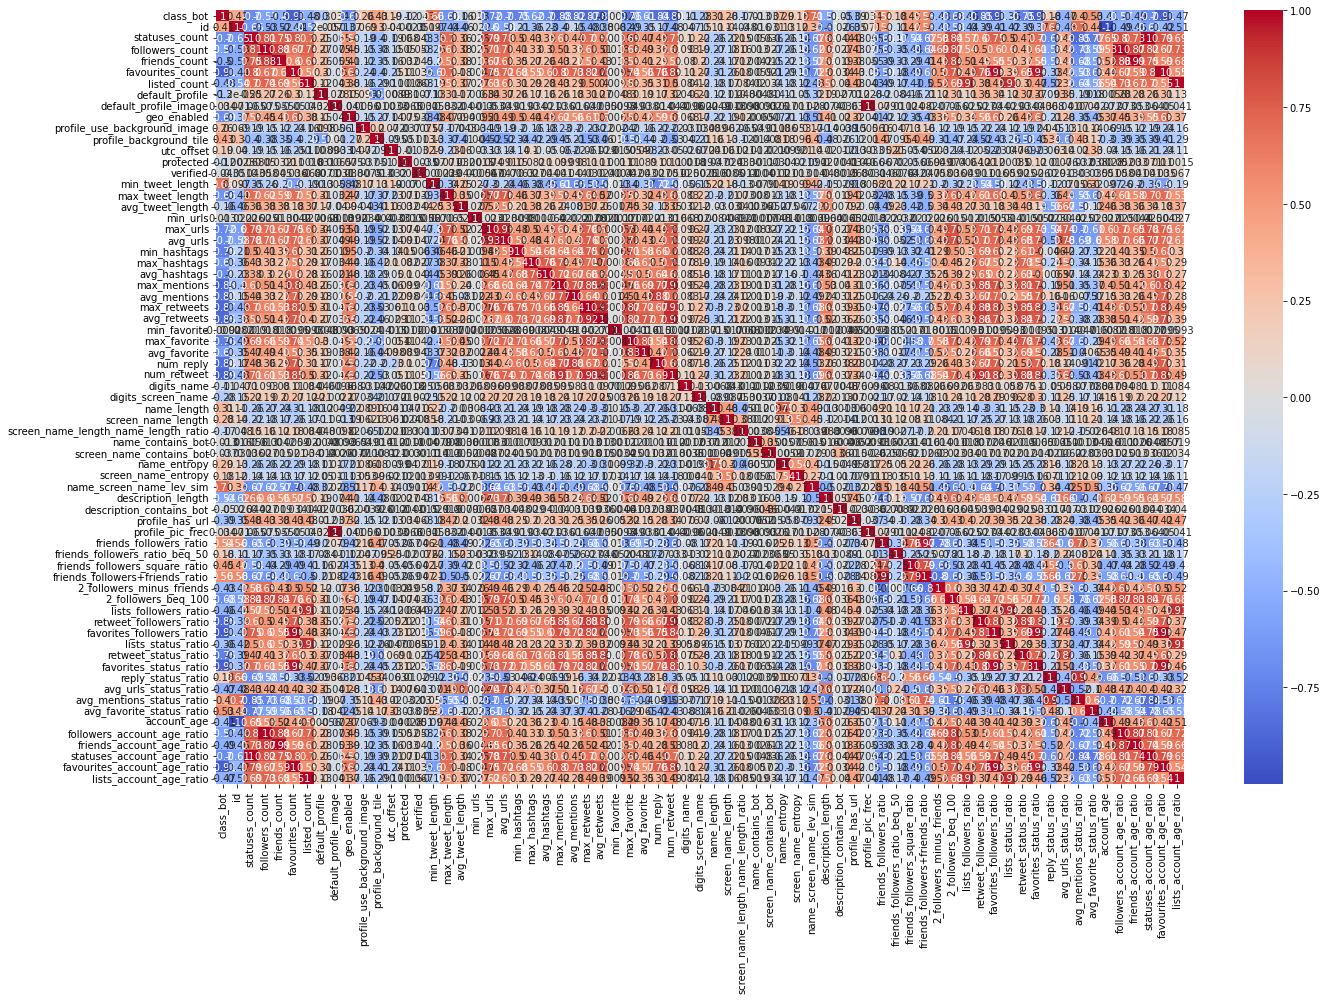

In [34]:
plt.figure(figsize=(20,14))
sns.heatmap(training_data.corr(method='spearman'), cmap='coolwarm', annot=True)
plt.tight_layout()
plt.show()

**Result**

The strongest correlations to target are:

lists_followers_ratio, retweet_followers_ratio,favorites_followers_ratio, list_status_ratio, retweet_status_ratio, favorites_status_ratio, followers_account_age_ratio, friends_account_age_ratio,
statuses_account_age_ratio, favorites_account_age_ratio, lists_account_age_ratio

### Feature Engineering

### Features selection using ANOVA F-function

Automatic feature selection

In [35]:
# ANOVA feature selection for numeric input and categorical output
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


In [36]:
#X = training_data.iloc[:,1:]
#y = training_data.iloc[:,0]
target = ['class_bot']
user_id = ['id']

cols = [col for col in training_data.columns if col not in user_id+target]

# Defining X (features) and Y (target)
X = training_data[cols]
Y = training_data.class_bot

#array = training_data.values
#X = array[:,1:]
#Y = array[:,0]

In [37]:
X.shape

(8386, 67)

In [38]:
Y

0       0
1       0
2       0
3       0
4       0
       ..
8381    1
8382    1
8383    1
8384    1
8385    1
Name: class_bot, Length: 8386, dtype: int64

In [39]:
from sklearn.feature_selection import mutual_info_classif

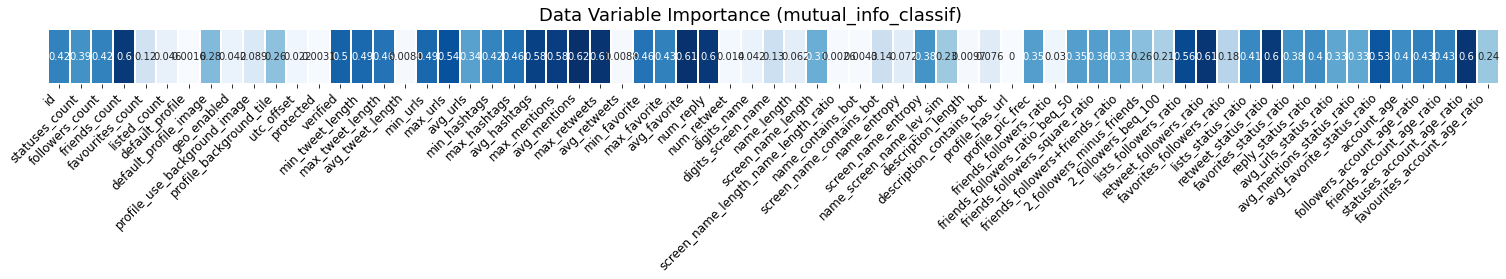

In [40]:
data_mutual_information = mutual_info_classif(X, Y)

plt.subplots(1, figsize=(26, 1))
sns.heatmap(data_mutual_information[:, np.newaxis].T, cmap='Blues', cbar=False, linewidths=1, annot=True)
plt.yticks([], [])
plt.gca().set_xticklabels(training_data.columns[1:], rotation=45, ha='right', fontsize=12)
plt.suptitle("Data Variable Importance (mutual_info_classif)", fontsize=18, y=1.2)
plt.gcf().subplots_adjust(wspace=0.2)
pass

In [41]:
from sklearn.feature_selection import GenericUnivariateSelect

In [42]:
trans = GenericUnivariateSelect(score_func=mutual_info_classif, mode='percentile', param=30)
X_trans = trans.fit_transform(X, Y)

In [43]:
print("We started with {0} features but retained only {1} of them!".format(X.shape[1] - 1, X_trans.shape[1]))

We started with 66 features but retained only 20 of them!


In [44]:
trans.get_support()

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False,  True,  True,  True, False,  True,
        True, False, False,  True,  True,  True,  True,  True, False,
        True, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False,  True, False, False, False, False,  True, False,
        True, False,  True, False])

In [45]:
# Check retained columns
columns_retained_Select = training_data.iloc[:, 2:].columns[trans.get_support()].values
pd.DataFrame(X_trans, columns=columns_retained_Select).head()

,favourites_count,min_tweet_length,max_tweet_length,avg_tweet_length,max_urls,avg_urls,avg_hashtags,max_mentions,avg_mentions,max_retweets,avg_retweets,max_favorite,num_reply,num_retweet,retweet_followers_ratio,favorites_followers_ratio,favorites_status_ratio,account_age,friends_account_age_ratio,favourites_account_age_ratio
0,3804.0,4.0,148.0,110.394992,2.0,0.297653,0.368388,7.0,1.112989,21325.0,75.970266,40.0,1084.0,911.0,0.128946,0.538429,0.083011,127286.0,0.014314,0.029885
1,634.0,3.0,151.0,84.894096,2.0,0.163386,0.360512,7.0,0.711965,296689.0,283.785067,19.0,899.0,561.0,0.355739,0.402029,0.053866,127119.0,0.005334,0.004987
2,42.0,2.0,158.0,81.207853,4.0,0.123715,0.040199,7.0,0.959177,13121.0,32.989716,8.0,1664.0,221.0,0.354735,0.067416,0.001073,126923.0,0.004168,0.000331
3,361.0,9.0,148.0,84.698516,2.0,0.461657,0.269944,6.0,0.682127,321639.0,199.153370,7.0,1122.0,276.0,0.170370,0.222840,0.020017,126899.0,0.004657,0.002845
4,5897.0,1.0,157.0,95.519011,2.0,0.063988,0.051932,8.0,0.782380,16181.0,43.263060,32.0,1387.0,390.0,0.475030,7.182704,0.262135,126567.0,0.004361,0.046592


In [46]:
features_selected = ['friends_followers_ratio', 'avg_mentions_status_ratio', 'max_retweets','avg_favorite_status_ratio','retweet_followers_ratio', 'retweet_status_ratio']

**Los datos que se requerirán extraer de la API Twitter:**

1. id
2. user_mentions ? ('avg_mentions')
3. user__favourites_count
4. user__statuses_count
5. user__followers_count
6. user__friends_count
7. retweet_count  (max_retweets)

In [47]:
# Defining X (features) and Y (target)
X = training_data[features_selected]
Y = training_data.class_bot

In [48]:
X.head()

,friends_followers_ratio,avg_mentions_status_ratio,max_retweets,avg_favorite_status_ratio,retweet_followers_ratio,retweet_status_ratio
0,0.257891,0.000024,21325.0,0.000011,0.128946,0.019880
1,0.429930,0.000060,296689.0,0.000035,0.355739,0.047664
2,0.849117,0.000024,13121.0,0.000004,0.354735,0.005644
3,0.364815,0.000038,321639.0,0.000005,0.170370,0.015304
4,0.672351,0.000035,16181.0,0.000023,0.475030,0.017336


In [49]:
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: class_bot, dtype: int64

In [50]:
features_corr = ['friends_followers_ratio', 'avg_mentions_status_ratio', 'max_retweets','avg_favorite_status_ratio','retweet_followers_ratio', 'retweet_status_ratio','class_bot']
data = training_data[features_corr]

In [51]:
data.corr(method='spearman')

,friends_followers_ratio,avg_mentions_status_ratio,max_retweets,avg_favorite_status_ratio,retweet_followers_ratio,retweet_status_ratio,class_bot
friends_followers_ratio,1.000000,0.717854,-0.662002,0.373839,-0.507704,-0.582928,0.540874
avg_mentions_status_ratio,0.717854,1.000000,-0.538214,0.600517,-0.391828,-0.356540,0.402490
max_retweets,-0.662002,-0.538214,1.000000,-0.410450,0.875817,0.850170,-0.868470
avg_favorite_status_ratio,0.373839,0.600517,-0.410450,1.000000,-0.336946,-0.154376,0.530363
retweet_followers_ratio,-0.507704,-0.391828,0.875817,-0.336946,1.000000,0.893455,-0.850840
retweet_status_ratio,-0.582928,-0.356540,0.850170,-0.154376,0.893455,1.000000,-0.750011
class_bot,0.540874,0.402490,-0.868470,0.530363,-0.850840,-0.750011,1.000000


In [52]:
from sklearn.preprocessing import StandardScaler

In [53]:
scaler = StandardScaler()

### Feature Extraction

In [54]:
#training_data['listed_count_binary'] = (training_data.listed_count>20000)==False
#features = ['screen_name_binary', 'name_binary', 'description_binary', 'status_binary', 'verified', 'followers_count', 'friends_count', 'statuses_count','listed_count_binary', 'bot']



6   followers_count        2797 non-null   int64  
 7   friends_count          2797 non-null   int64  
 8   listed_count           2797 non-null   int64  
 9   created_at             2797 non-null   object
 10  favourites_count       2797 non-null   int64 
 12  statuses_count         2797 non-null   int64  

In [ ]:
file_1 = FOLDER_PATH+'/dataset_yulimars.csv'

In [ ]:
# Cargamos los datos de prueba
df = pd.read_csv(file_1, parse_dates=['created_at'], low_memory=False)

In [ ]:
df.columns

Index(['Unnamed: 0', 'id', 'created_at', 'name', 'screen_name', 'text',
       'mentions', 'favourites_count', 'statuses_count', 'followers_count',
       'friends_count', 'retweet_count', 'location'],
      dtype='object')

In [ ]:
df['screen_name'].value_counts()

rocio24628915      10
aliciacug1979       8
karem306093851      8
franklinjardin1     7
leidy73166550       7
                   ..
IdrisAdeyemo31      1
MariaGVzla81        1
C_CMiraflores       1
2doCmdteCzgnb63     1
2cmdte51monagas     1
Name: screen_name, Length: 567, dtype: int64

In [ ]:
df.head()

,Unnamed: 0,id,created_at,name,screen_name,text,mentions,favourites_count,statuses_count,followers_count,friends_count,retweet_count,location
0,0,1583569457485860864,2022-10-21 21:22:34,Alfonso Urdaneta. V,MaykolFeo1,RT @Monsalve3Denis: Yulimar Rojas está cumplie...,"Monsalve3Denis,TeamRojas45",576,775,607,636,65,"Estado Zulia, Venezuela 🇻🇪"
1,1,1583569443292315649,2022-10-21 21:22:31,lubin ducallin,DucallinLubin,RT @torrealbaf: Enviamos nuestras felicitacion...,"torrealbaf,TeamRojas45",10,29066,88,127,107,NaN
2,2,1583569433200508928,2022-10-21 21:22:28,nixon Servando,gonjohana820,RT @fundasaludccs: Feliz cumpleaños a la grand...,fundasaludccs,0,11079,55,18,69,NaN
3,3,1583569418818240512,2022-10-21 21:22:25,Lerwin Mora,mora_lerwin,RT @Monsalve3Denis: Yulimar Rojas está cumplie...,"Monsalve3Denis,TeamRojas45",82,20229,151,70,65,NaN
4,4,1583569412853886976,2022-10-21 21:22:23,irene alvarado,ireneal31741693,RT @2DACIASABANETA: Hoy #21Oct celebramos el C...,2DACIASABANETA,5,9558,114,149,33,NaN


Feature integrity


In [55]:
def feature_int(df):
  """
  Esta función tiene por objetivo filtrar los valores nulos o NaN y validar
  la integridad de los datos que se usarán en la creación de los atributos para
  entrenar el modelo de ML.

  Entrada: dataframe 'df' pandas.
  Salida: df pandas con las siete (7) columnas y sus datos validados.

  'created_at', 'name', 'screen_name', 'text',
       'mentions', 'favourites_count', 'statuses_count', 'followers_count',
       'friends_count', 'retweet_count', 'location'

  """
  df['mentions'] = df.mentions.apply(lambda x: 'nan' if x=='' else str(x))
  df['favourites_count'] = df.favourites_count.apply(lambda x: 0 if x=='' else int(x))
  df['statuses_count'] = df.statuses_count.apply(lambda x: 0 if x=='' else int(x))
  df['followers_count'] = df.followers_count.apply(lambda x: 0 if x=='' else int(x))
  df['friends_count'] = df.friends_count.apply(lambda x: 0 if x=='' else int(x))
  df['retweet_count'] = df.retweet_count.apply(lambda x: 0 if x=='' else int(x))
  df['location'] = df.location.apply(lambda x: 'N/A' if x== None else str(x))
  return df

In [ ]:
df = feature_int(df)

In [ ]:
df.head()

,Unnamed: 0,id,created_at,name,screen_name,text,mentions,favourites_count,statuses_count,followers_count,friends_count,retweet_count,location
0,0,1583569457485860864,2022-10-21 21:22:34,Alfonso Urdaneta. V,MaykolFeo1,RT @Monsalve3Denis: Yulimar Rojas está cumplie...,"Monsalve3Denis,TeamRojas45",576,775,607,636,65,"Estado Zulia, Venezuela 🇻🇪"
1,1,1583569443292315649,2022-10-21 21:22:31,lubin ducallin,DucallinLubin,RT @torrealbaf: Enviamos nuestras felicitacion...,"torrealbaf,TeamRojas45",10,29066,88,127,107,nan
2,2,1583569433200508928,2022-10-21 21:22:28,nixon Servando,gonjohana820,RT @fundasaludccs: Feliz cumpleaños a la grand...,fundasaludccs,0,11079,55,18,69,nan
3,3,1583569418818240512,2022-10-21 21:22:25,Lerwin Mora,mora_lerwin,RT @Monsalve3Denis: Yulimar Rojas está cumplie...,"Monsalve3Denis,TeamRojas45",82,20229,151,70,65,nan
4,4,1583569412853886976,2022-10-21 21:22:23,irene alvarado,ireneal31741693,RT @2DACIASABANETA: Hoy #21Oct celebramos el C...,2DACIASABANETA,5,9558,114,149,33,nan


Calculating the new features

Let's create a function

In [56]:
import numpy as np

def features_creation(df):
  """
  Esta función tiene por objetivo realizar los cálculos para obtener los nuevos
  atributos o 'features' que serán utilizados para entrenar el modelo de ML.

  Entrada: dataframe 'df' pandas.
  Salida: 'df' pandas con once (11) columnas adicionales de los atributos ya calculados.

  """

  features_selected = ['friends_followers_ratio', 'avg_mentions_status_ratio', 
                       'max_retweets','avg_favorite_status_ratio','retweet_followers_ratio', 
                       'retweet_status_ratio']

  # Calculamos 'friends_followers_ratio'
  df['friends_followers_ratio'] =  round((df['friends_count']/df['followers_count']), 4)

  # Calculamos 'avg_mentions_status_ratio'
  df['mentions_count'] = df.mentions.apply(lambda x: 0 if x==' ' else len(str(x).split(',')))
  df['mentions_status_ratio'] =  round((df['mentions_count']/df['statuses_count']), 4)
  #avg_mentions_status_dict = dict(df.groupby('screen_name')['mentions_status_ratio'].mean())
  #df['avg_mentions_status_ratio'] = df['screen_name'].apply(lambda x: avg_mentions_status_dict.get(x))

  # Calculamos el 'max_retweets' por usuario
  retweet_dict = dict(df.groupby('screen_name')['retweet_count'].max())
  df['max_retweets'] = df['screen_name'].apply(lambda x: retweet_dict.get(x))

  # Calculamos 'avg_favorite_status_ratio'
  df['favorite_status_ratio'] = round((df['favourites_count']/df['statuses_count']), 4)
  #avg_favorite_status_dict = dict(df.groupby('screen_name')['favorite_status_ratio'].mean())
  #df['avg_favorite_status_ratio'] = df['screen_name'].apply(lambda x: avg_favorite_status_dict.get(x))

  # Calculamos 'retweet_followers_ratio'
  df['retweet_followers_ratio'] =  round((df['retweet_count']/df['followers_count']), 4)
  #retweet_followers_ratio_dict = dict(df.groupby('screen_name')['retweet_followers_ratio'].mean())
  #df['avg_retweet_followers_ratio'] = df['screen_name'].apply(lambda x: retweet_followers_ratio_dict.get(x))

  # Calculamos 'retweet_status_ratio'
  df['retweet_status_ratio'] =  round((df['retweet_count']/df['statuses_count']), 4)
  #avg_retweet_status_dict = dict(df.groupby('screen_name')['retweet_status_ratio'].mean())
  #df['avg_retweet_status_ratio'] = df['screen_name'].apply(lambda x: avg_retweet_status_dict.get(x))

  df_group = df.groupby(['screen_name'], as_index=True, sort=False)[['friends_followers_ratio', 'mentions_status_ratio', 
                       'max_retweets','favorite_status_ratio','retweet_followers_ratio', 
                       'retweet_status_ratio']].mean()
  
  return df_group


In [ ]:
df_yulimar = features_creation(df)

In [ ]:
df_yulimar.head(35)

,friends_followers_ratio,mentions_status_ratio,max_retweets,favorite_status_ratio,retweet_followers_ratio,retweet_status_ratio
screen_name,,,,,,
MaykolFeo1,1.0478,0.001950,84.0,0.7432,0.122750,0.096150
DucallinLubin,1.4432,0.000100,107.0,0.0003,1.215900,0.003700
gonjohana820,0.3273,0.000150,69.0,0.0000,1.218150,0.006050
mora_lerwin,0.4636,0.000033,158.0,0.0041,0.609283,0.004550
ireneal31741693,1.3070,0.000100,43.0,0.0005,0.280700,0.003367
Daygole1,0.0985,0.000120,158.0,0.0001,0.493600,0.005640
xanmirfour,0.0588,0.000400,158.0,0.0018,2.862767,0.019000
Luis91422048,0.0930,0.000033,84.0,0.0056,0.281633,0.002233
jordang22835591,0.2536,0.000000,69.0,0.0002,0.289850,0.001800


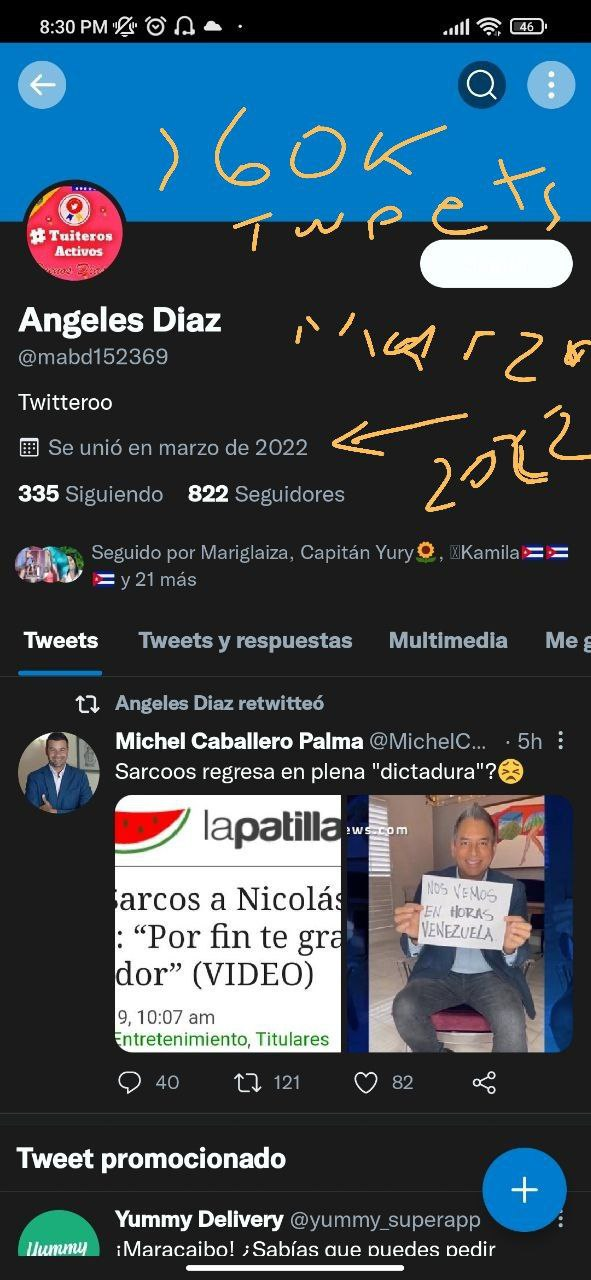

In [ ]:
#df.set_index('screen_name', inplace=True)
df_group = df.groupby(['screen_name'], as_index=True, sort=False)
df_group.head()


,Unnamed: 0,id,created_at,name,screen_name,text,mentions,favourites_count,statuses_count,followers_count,friends_count,retweet_count,location
0,0,1583569457485860864,2022-10-21 21:22:34,Alfonso Urdaneta. V,MaykolFeo1,RT @Monsalve3Denis: Yulimar Rojas está cumplie...,"Monsalve3Denis,TeamRojas45",576,775,607,636,65,"Estado Zulia, Venezuela 🇻🇪"
1,1,1583569443292315649,2022-10-21 21:22:31,lubin ducallin,DucallinLubin,RT @torrealbaf: Enviamos nuestras felicitacion...,"torrealbaf,TeamRojas45",10,29066,88,127,107,nan
2,2,1583569433200508928,2022-10-21 21:22:28,nixon Servando,gonjohana820,RT @fundasaludccs: Feliz cumpleaños a la grand...,fundasaludccs,0,11079,55,18,69,nan
3,3,1583569418818240512,2022-10-21 21:22:25,Lerwin Mora,mora_lerwin,RT @Monsalve3Denis: Yulimar Rojas está cumplie...,"Monsalve3Denis,TeamRojas45",82,20229,151,70,65,nan
4,4,1583569412853886976,2022-10-21 21:22:23,irene alvarado,ireneal31741693,RT @2DACIASABANETA: Hoy #21Oct celebramos el C...,2DACIASABANETA,5,9558,114,149,33,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,1583527034361643009,2022-10-21 18:34:00,eudys antonio,EeudysTD,RT @BachaqueroGNB: #21Oct #PatriaUnidaYSolidar...,BachaqueroGNB,16,47248,226,20,8,nan
996,996,1583526949385011200,2022-10-21 18:33:39,Portillito15 👜👠,portillito15,RT @CZGNB_D512_3ERA: #21Oct de 1995 Nace Yulim...,CZGNB_D512_3ERA,2,15883,121,32,21,nan
997,997,1583526930212847616,2022-10-21 18:33:35,Yuri Cortez,YuriYurisky,La campeona @TeamRojas45 Yulimar Rojas disfrut...,TeamRojas45,10201,6392,29076,1613,0,Venezuela
998,998,1583526923640004609,2022-10-21 18:33:33,gerardo,gerardo45618681,RT @PascualinoFull: Yulimar Rojas nació en Car...,PascualinoFull,23,1653,50,65,43,nan


In [ ]:
print(df.groupby('screen_name').ngroups)

567


In [ ]:
#n = len(pd.unique(df['screen_name']))
#print(n)

In [ ]:
df['mentions_count'] = df.mentions.apply(lambda x: 0 if x==' ' else len(str(x).split(',')))

In [ ]:
#df['max_retweets'] = df.groupby('screen_name')['retweet_count'].max() #agg('max')

In [ ]:
#df['avg_mentions_status_ratio'] =  df['mentions_count']/df['statuses_count']
#df['mentions_status_ratio'] = df.groupby('screen_name')\
                            #.apply(lambda x: x.mentions_count/x.statuses_count)

In [ ]:
df.head()

,Unnamed: 0,id,created_at,name,screen_name,text,mentions,favourites_count,statuses_count,followers_count,...,location,mentions_count,friends_followers_ratio,max_retweets,mentions_status_ratio,avg_mentions_status_ratio,retweet_followers_ratio,avg_retweet_followers_ratio,retweet_status_ratio,avg_retweet_status_ratio
0,0,1583569457485860864,2022-10-21 21:22:34,Alfonso Urdaneta. V,MaykolFeo1,RT @Monsalve3Denis: Yulimar Rojas está cumplie...,"Monsalve3Denis,TeamRojas45",576,775,607,...,"Estado Zulia, Venezuela 🇻🇪",2,1.047776,84,0.002581,0.001935,0.107084,0.122735,0.083871,0.096129
1,1,1583569443292315649,2022-10-21 21:22:31,lubin ducallin,DucallinLubin,RT @torrealbaf: Enviamos nuestras felicitacion...,"torrealbaf,TeamRojas45",10,29066,88,...,nan,2,1.443182,107,0.000069,0.000069,1.215909,1.215909,0.003681,0.003681
2,2,1583569433200508928,2022-10-21 21:22:28,nixon Servando,gonjohana820,RT @fundasaludccs: Feliz cumpleaños a la grand...,fundasaludccs,0,11079,55,...,nan,1,0.327273,69,0.000090,0.000135,1.254545,1.218182,0.006228,0.006047
3,3,1583569418818240512,2022-10-21 21:22:25,Lerwin Mora,mora_lerwin,RT @Monsalve3Denis: Yulimar Rojas está cumplie...,"Monsalve3Denis,TeamRojas45",82,20229,151,...,nan,2,0.463576,158,0.000099,0.000074,0.430464,0.609272,0.003213,0.004548
4,4,1583569412853886976,2022-10-21 21:22:23,irene alvarado,ireneal31741693,RT @2DACIASABANETA: Hoy #21Oct celebramos el C...,2DACIASABANETA,5,9558,114,...,nan,1,1.307018,43,0.000105,0.000105,0.289474,0.280702,0.003453,0.003348


Los atributos que serán usados en el entrenamiento del modelo

In [ ]:
#features = ['lists_followers_ratio', 'retweet_followers_ratio','favorites_followers_ratio', 'lists_status_ratio', 'retweet_status_ratio', 'favorites_status_ratio',
            #'followers_account_age_ratio', 'friends_account_age_ratio','statuses_account_age_ratio', 'favourites_account_age_ratio', 'lists_account_age_ratio', 'class_bot']

### Implementing Different Models

Decision Tree Classifier

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split

In [ ]:
#X = training_data[features].iloc[:,:-1]
#y = training_data[features].iloc[:,-1]

In [58]:
dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=50, min_samples_split=10)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=101)

# Normalizamos todas las variables de atributos
#scaler.fit(X_train)
#X_train_new = scaler.transform(X_train)
#X_test_new = scaler.transform(X_test)

In [ ]:
X_test.head()

,friends_followers_ratio,avg_mentions_status_ratio,max_retweets,avg_favorite_status_ratio,retweet_followers_ratio,retweet_status_ratio
7039,19.500000,0.008433,1.000000,0.001022,0.000000,0.000000
692,0.094799,0.000033,530845.000000,0.000011,0.345638,0.024297
739,2.601626,0.000119,113386.000000,0.000028,0.804878,0.048482
3199,0.870654,0.000020,269075.638966,0.000012,0.947876,0.018151
8174,2.600000,0.000000,1.000000,0.000001,0.000000,0.000000


In [ ]:
dt = dt.fit(X_train, y_train)
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

In [ ]:
y_pred_test

array([1, 0, 0, ..., 1, 1, 1])

In [ ]:
print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

Trainig Accuracy: 0.98601
Test Accuracy: 0.98283


In [ ]:
def plot_roc(X_train, X_test, clf):
  sns.set(font_scale=1.5)
  sns.set_style("whitegrid", {'axes.grid' : False})

  scores_train = clf.predict_proba(X_train)
  scores_test = clf.predict_proba(X_test)
  y_scores_train = []
  y_scores_test = []
  for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

  for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
  fpr_dt_train, tpr_dt_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
  fpr_dt_test, tpr_dt_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

  plt.plot(fpr_dt_train, tpr_dt_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_dt_train, tpr_dt_train))
  plt.plot(fpr_dt_test, tpr_dt_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_dt_test, tpr_dt_test))
  plt.title("ROC Curve")
  plt.xlabel("False Positive Rate (FPR)")
  plt.ylabel("True Positive Rate (TPR)")
  plt.legend(loc='lower right')


In [ ]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = dt.predict_proba(X_train)
scores_test = dt.predict_proba(X_test)


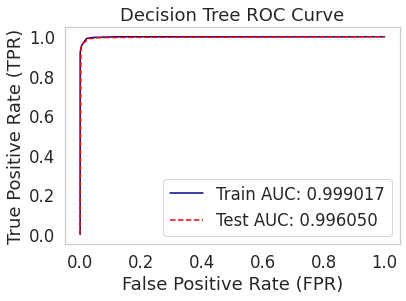

In [ ]:
y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_dt_train, tpr_dt_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_dt_test, tpr_dt_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_dt_train, tpr_dt_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_dt_train, tpr_dt_train))
plt.plot(fpr_dt_test, tpr_dt_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_dt_test, tpr_dt_test))
plt.title("Decision Tree ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

Resultado: 

Decision Tree tiene buen desempeño y generaliza bien. Pero pudiera tener "overfitting" por el AUC = 0.99, así que probaremos otros modelos.

Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(criterion='entropy', min_samples_leaf=100, min_samples_split=20)

#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

rf = rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

In [ ]:
print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

Trainig Accuracy: 0.98187
Test Accuracy: 0.97854


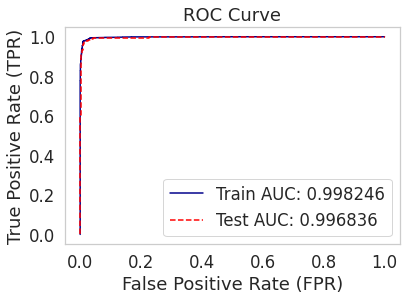

In [ ]:
plot_roc(X_train, X_test, rf)

XGBoost Classifier

In [ ]:
xgb = xgb.XGBClassifier(objective="binary:logistic", random_state=42, learning_rate = 0.05, n_estimators = 5000, early_stopping_rounds = 10)

In [ ]:
xgb_model = xgb.fit(X_train, y_train)
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

In [ ]:
print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

Trainig Accuracy: 1.00000
Test Accuracy: 0.98951


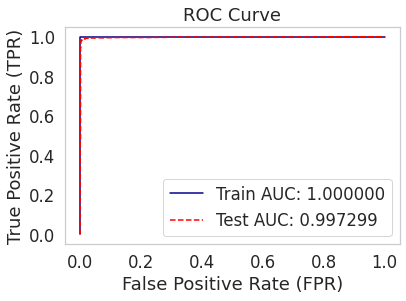

In [ ]:
plot_roc(X_train_new, X_test_new, xgb_model)

K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

In [ ]:
knn_model = knn.fit(X_train, y_train)
y_pred_train = knn_model.predict(X_train)
y_pred_test = knn_model.predict(X_test)

In [ ]:
print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

Trainig Accuracy: 0.98935
Test Accuracy: 0.98188


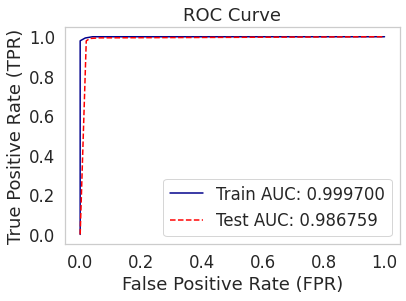

In [ ]:
plot_roc(X_train, X_test, knn_model)

Support Vector Machine (SVM)

In [59]:
from sklearn.svm import SVC

In [60]:
clf = SVC(kernel='rbf', random_state=1, gamma=1.0, C=100.0)

In [61]:
clf.fit(X_train, y_train)

SVC(C=100.0, gamma=1.0, random_state=1)

In [62]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [63]:
print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

Trainig Accuracy: 0.99905
Test Accuracy: 0.97568


In [64]:
import pickle

In [65]:
# Guardamos el modelo SVC
pickle.dump(clf, open('bot_model.pkl', 'wb'))

In [ ]:
from matplotlib.colors import ListedColormap
def decision_boundary(X,y,model,res,test_idx=None):
    markers=['s','o','x']
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    colormap=ListedColormap(colors[:len(np.unique(y))])
    x_min,x_max=X[:,0].min()-1,X[:,0].max()+1
    y_min,y_max=X[:,1].min()-1,X[:,1].max()+1
    xx,yy=np.meshgrid(np.arange(x_min,x_max,res),np.arange(y_min,y_max,res))
    z=model.predict(np.c_[xx.ravel(), yy.ravel()])
    zz=z.reshape(xx.shape)
    plt.pcolormesh(xx,yy,zz,cmap=colormap)

    for idx,cl in enumerate(np.unique(y)):
        plt.scatter(X[y==cl,0],X[y==cl,1],c=colors[idx],cmap=plt.cm.Paired, edgecolors='k',marker=markers[idx],label=cl,alpha=0.8)

In [ ]:
X_train

array([[ 0.14066767,  0.5769734 , -0.42450886, -0.03875172, -0.15941142,
        -0.1051676 ],
       [ 0.40521031,  0.29848062, -0.42450886,  0.03853433, -0.15941142,
        -0.1051676 ],
       [ 0.04909521,  0.80838321, -0.42450504, -0.06341893, -0.15941142,
        -0.1051676 ],
       ...,
       [-0.35869342, -0.48566595, -0.42450886, -0.36525596, -0.15941142,
        -0.1051676 ],
       [-0.60398368, -0.48028411,  0.6019887 , -0.35966038, -0.03967763,
        -0.09825688],
       [-0.58778391, -0.48511034,  0.6019887 , -0.36490994, -0.15665236,
        -0.10445415]])

### AdaBoost model

In [ ]:
# Import the AdaBoost classifier
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
# importing required module
from sklearn.model_selection import GridSearchCV

# initializing the model
model=AdaBoostClassifier()

# applying GridSearchCV
grid=GridSearchCV(estimator=model,param_grid={'n_estimators':range(1,50)})

# training the model
grid.fit(X_train,y_train)

# printing the best estimator
print("The best estimator returned by GridSearch CV is:", grid.best_estimator_)

The best estimator returned by GridSearch CV is: AdaBoostClassifier(n_estimators=46)


In [ ]:
# Create adaboost classifer with 5 stump trees
Ada_classifier = AdaBoostClassifier(n_estimators=46)

# Train Adaboost Classifer
AdaBoost = Ada_classifier.fit(X_train, y_train)

#Predict the response for test dataset
AdaBoost_pred = AdaBoost.predict(X_test)

# printing
print("The accuracy of the model is:  ", accuracy_score(y_test, AdaBoost_pred))

The accuracy of the model is:   0.9823557463042442


In [ ]:
df_yulimar = df_yulimar.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
df_yulimar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   friends_followers_ratio  567 non-null    float64
 1   mentions_status_ratio    567 non-null    float64
 2   max_retweets             567 non-null    float64
 3   favorite_status_ratio    567 non-null    float64
 4   retweet_followers_ratio  567 non-null    float64
 5   retweet_status_ratio     567 non-null    float64
dtypes: float64(6)
memory usage: 26.7 KB


In [ ]:
#yulimar_new = scaler.transform(df_yulimar)
yulimar_predictions = clf.predict(df_yulimar)
yulimar_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [ ]:
df_yulimar['predictions'] = pd.DataFrame(yulimar_predictions)

In [ ]:
df_yulimar.head(30)

,friends_followers_ratio,mentions_status_ratio,max_retweets,favorite_status_ratio,retweet_followers_ratio,retweet_status_ratio,predictions
0,1.0478,0.001950,84.0,0.7432,0.122750,0.096150,0
1,1.4432,0.000100,107.0,0.0003,1.215900,0.003700,0
2,0.3273,0.000150,69.0,0.0000,1.218150,0.006050,0
3,0.4636,0.000033,158.0,0.0041,0.609283,0.004550,0
4,1.3070,0.000100,43.0,0.0005,0.280700,0.003367,0
5,0.0985,0.000120,158.0,0.0001,0.493600,0.005640,0
6,0.0588,0.000400,158.0,0.0018,2.862767,0.019000,0
7,0.0930,0.000033,84.0,0.0056,0.281633,0.002233,0
8,0.2536,0.000000,69.0,0.0002,0.289850,0.001800,0
9,0.1461,0.000167,158.0,0.0000,1.509367,0.015300,0


### Load data for models testing 

In [ ]:
file1= FOLDER_PATH+'/training_data_2_csv_UTF.csv'
testing_data = pd.read_csv(file1, low_memory=False)

In [ ]:
testing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2797 entries, 0 to 2796
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2797 non-null   float64
 1   id_str                 2797 non-null   object 
 2   screen_name            2797 non-null   object 
 3   location               1777 non-null   object 
 4   description            2394 non-null   object 
 5   url                    1455 non-null   object 
 6   followers_count        2797 non-null   int64  
 7   friends_count          2797 non-null   int64  
 8   listed_count           2797 non-null   int64  
 9   created_at             2797 non-null   object 
 10  favourites_count       2797 non-null   int64  
 11  verified               2797 non-null   bool   
 12  statuses_count         2797 non-null   int64  
 13  lang                   2797 non-null   object 
 14  status                 2508 non-null   object 
 15  defa

In [ ]:
testing_data['bot'].value_counts()

0    1476
1    1321
Name: bot, dtype: int64

In [ ]:
def predict_bot(clf, X_test):
  prediction = clf.predict(X_test)

In [ ]:
#Create a classification model with set parameters, and then instead of fitting,
#load my model from the included JSON

#classification_model.load_model('/content/graph_classifier_3.json')

#Make a prediction
#pred = classification_model.predict(embeddingsframe)
#print(screen_name + ': ' + pred[0])